# Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install biopython obonet --quiet
!pip install torch torchvision torchaudio --quiet
!pip install transformers biopython --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

# 🧩 CAFA6 Data Loading & Parsing (Step 1)

In [3]:
%%time
# =========================================================
# CAFA6 - Step 1: Load & Explore Data
# =========================================================
import pandas as pd

from Bio import SeqIO
import obonet

# ---------------------------------------------------------
# File paths (update if needed)
# ---------------------------------------------------------
BASE_PATH = "/kaggle/input/cafa-6-protein-function-prediction"
TRAIN_PATH = f"{BASE_PATH}/Train"
TEST_PATH = f"{BASE_PATH}/Test"

# ---------------------------------------------------------
# 1. Load TSV files
# ---------------------------------------------------------
train_terms = pd.read_csv(
    f"{TRAIN_PATH}/train_terms.tsv",
    sep="\t",
    names=["protein_id", "go_term", "ontology"]
)

train_taxonomy = pd.read_csv(
    f"{TRAIN_PATH}/train_taxonomy.tsv",
    sep="\t",
    names=["protein_id", "taxon_id"]
)

ia = pd.read_csv(
    f"{BASE_PATH}/IA.tsv",
    sep="\t",
    names=["go_term", "weight"]
)

# ---------------------------------------------------------
# 2. Load ontology graph (go-basic.obo)
# ---------------------------------------------------------
go_graph = obonet.read_obo(f"{TRAIN_PATH}/go-basic.obo")
print(f"Ontology terms loaded: {len(go_graph)}")

# Example: extract parent relationships
root_nodes = {
    'BP': 'GO:0008150',
    'CC': 'GO:0005575',
    'MF': 'GO:0003674'
}

# ---------------------------------------------------------
# 3. Load FASTA sequences (train & test superset)
# ---------------------------------------------------------
def load_fasta_sequences(file_path):
    """Return dict {protein_id: sequence}"""
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        prot_id = record.id.split("|")[1] if "|" in record.id else record.id
        sequences[prot_id] = str(record.seq)
    return sequences

train_sequences = load_fasta_sequences(f"{TRAIN_PATH}/train_sequences.fasta")
test_sequences = load_fasta_sequences(f"{TEST_PATH}/testsuperset.fasta")

print(f"Train sequences: {len(train_sequences)}")
print(f"Test superset sequences: {len(test_sequences)}")

# ---------------------------------------------------------
# 4. Merge annotations and taxonomy
# ---------------------------------------------------------
train_df = train_terms.merge(train_taxonomy, on="protein_id", how="left")
print(f"Train dataframe: {train_df.shape}")

# ---------------------------------------------------------
# 5. Quick data summary
# ---------------------------------------------------------
print("\nData Summary:")
print(f"- train_terms: {train_terms.shape}")
print(f"- train_taxonomy: {train_taxonomy.shape}")
print(f"- ia: {ia.shape}")
print(f"- train_sequences: {len(train_sequences)}")
print(f"- test_sequences: {len(test_sequences)}")
print(f"- Ontology terms (GO): {len(go_graph)}")

# Preview few examples
print("\nSample train_terms:")
display(train_terms.head())

print("\nSample train_taxonomy:")
display(train_taxonomy.head())

print("\nSample IA:")
display(ia.head())

# Example check of GO hierarchy
example_term = list(go_graph.nodes())[0]
print(f"\nExample GO term: {example_term}")
print("Parents:", list(go_graph.predecessors(example_term)))
print("Children:", list(go_graph.successors(example_term)))


Ontology terms loaded: 40122
Train sequences: 82404
Test superset sequences: 224309
Train dataframe: (537028, 4)

Data Summary:
- train_terms: (537028, 3)
- train_taxonomy: (82404, 2)
- ia: (40122, 2)
- train_sequences: 82404
- test_sequences: 224309
- Ontology terms (GO): 40122

Sample train_terms:


,protein_id,go_term,ontology
0,EntryID,term,aspect
1,Q5W0B1,GO:0000785,C
2,Q5W0B1,GO:0004842,F
3,Q5W0B1,GO:0051865,P
4,Q5W0B1,GO:0006275,P



Sample train_taxonomy:


,protein_id,taxon_id
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606



Sample IA:


,go_term,weight
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573



Example GO term: GO:0000001
Parents: []
Children: ['GO:0048308', 'GO:0048311']
CPU times: user 8.1 s, sys: 610 ms, total: 8.71 s
Wall time: 10.2 s


# 🧭 Step 2: Exploratory Data Analysis (EDA)

Below is a well-structured EDA section to add right after dataset loading.

It covers:

Overview of GO ontologies

Distribution of GO terms & taxonomies

Sequence length statistics

Relationship between ontology, taxonomy, and terms

Visualization of embeddings (optional)

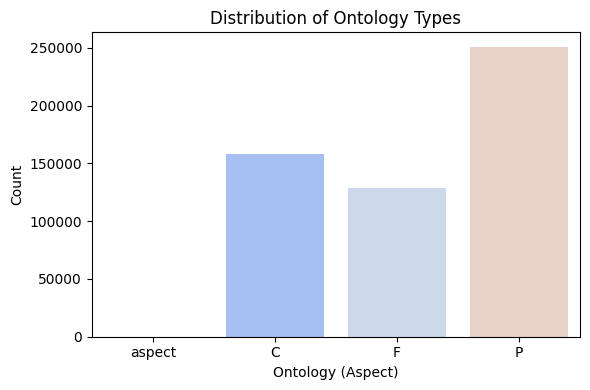

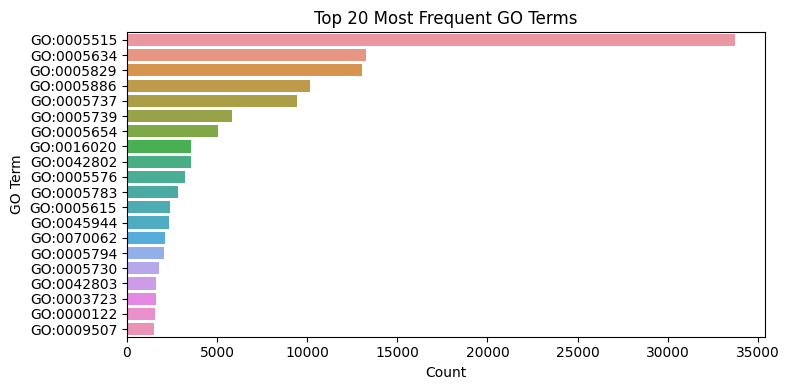

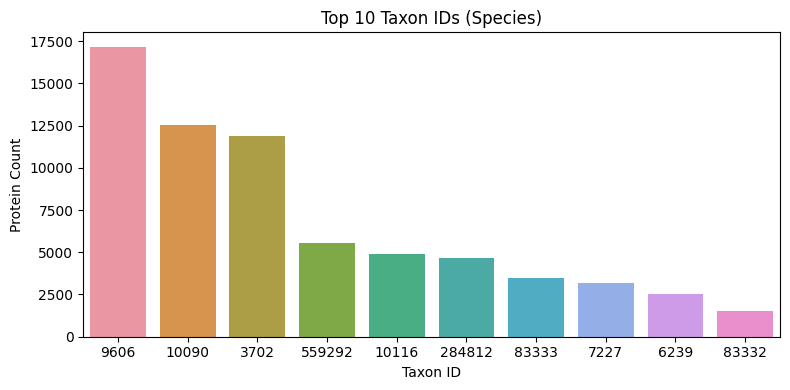

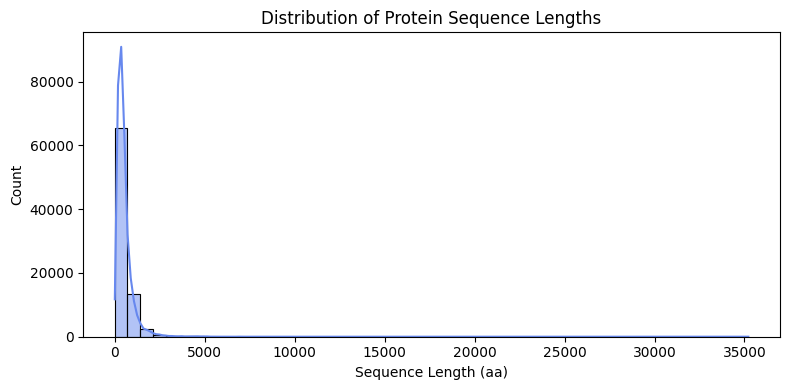

🧬 Average sequence length: 525.8 aa
Longest sequence: 35213 aa
Shortest sequence: 3 aa


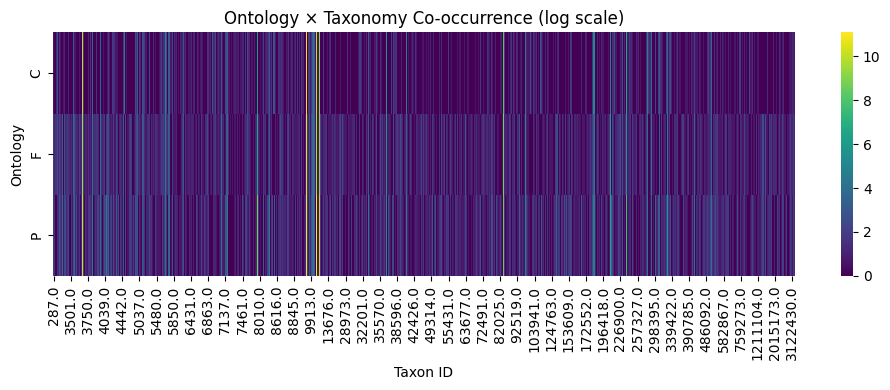

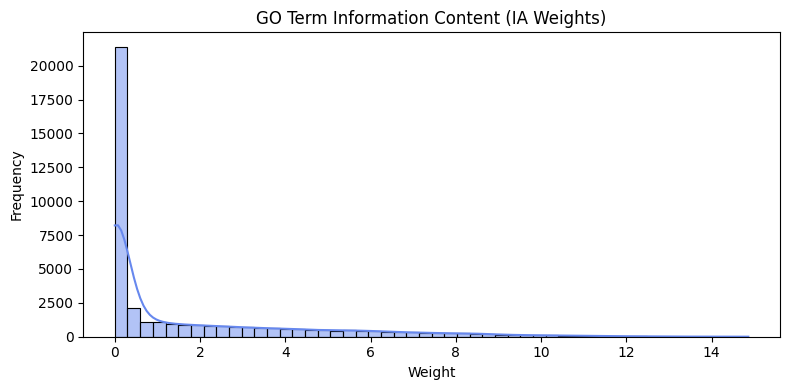

🧠 IA weights: mean=1.717, max=14.861
CPU times: user 4.55 s, sys: 240 ms, total: 4.79 s
Wall time: 4.17 s


In [4]:
%%time
# =========================================================
# Step 2: Exploratory Data Analysis (EDA)
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Style setup
plt.style.use("seaborn-v0_8-muted")
sns.set_palette("coolwarm")

# ---------------------------------------------------------
# 1. Ontology distribution
# ---------------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="ontology", data=train_terms)
plt.title("Distribution of Ontology Types")
plt.xlabel("Ontology (Aspect)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 2. GO term frequency
# ---------------------------------------------------------
go_counts = train_terms["go_term"].value_counts().head(20)
plt.figure(figsize=(8,4))
sns.barplot(y=go_counts.index, x=go_counts.values)
plt.title("Top 20 Most Frequent GO Terms")
plt.xlabel("Count")
plt.ylabel("GO Term")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 3. Taxonomy overview
# ---------------------------------------------------------
tax_counts = train_taxonomy["taxon_id"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=tax_counts.index.astype(str), y=tax_counts.values)
plt.title("Top 10 Taxon IDs (Species)")
plt.xlabel("Taxon ID")
plt.ylabel("Protein Count")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. Sequence length distribution
# ---------------------------------------------------------
seq_lengths = [len(seq) for seq in train_sequences.values()]
plt.figure(figsize=(8,4))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.title("Distribution of Protein Sequence Lengths")
plt.xlabel("Sequence Length (aa)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(f"🧬 Average sequence length: {np.mean(seq_lengths):.1f} aa")
print(f"Longest sequence: {np.max(seq_lengths)} aa")
print(f"Shortest sequence: {np.min(seq_lengths)} aa")

# ---------------------------------------------------------
# 5. Ontology × Taxonomy heatmap (co-occurrence)
# ---------------------------------------------------------
merged = train_terms.merge(train_taxonomy, on="protein_id", how="left")
ont_tax_counts = (
    merged.groupby(["ontology", "taxon_id"])
    .size()
    .reset_index(name="count")
    .pivot(index="ontology", columns="taxon_id", values="count")
    .fillna(0)
)
plt.figure(figsize=(10,4))
sns.heatmap(np.log1p(ont_tax_counts), cmap="viridis")
plt.title("Ontology × Taxonomy Co-occurrence (log scale)")
plt.xlabel("Taxon ID")
plt.ylabel("Ontology")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. IA weight distribution (Information Content)
# ---------------------------------------------------------
plt.figure(figsize=(8,4))
sns.histplot(ia["weight"], bins=50, kde=True)
plt.title("GO Term Information Content (IA Weights)")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print(f"🧠 IA weights: mean={ia['weight'].mean():.3f}, max={ia['weight'].max():.3f}")

# 🧬 Step 3 – Protein Embedding Extraction (ESM2 baseline)

In [5]:
%%time
# =========================================================
# Step 2: Extract Protein Embeddings using ESM2 (facebook/esm2_t6_8M_UR50D)
# =========================================================


import torch
from transformers import AutoTokenizer, AutoModel
from Bio import SeqIO
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# ---------------------------------------------------------
# Load model + tokenizer
# ---------------------------------------------------------
MODEL_NAME = "facebook/esm2_t6_8M_UR50D"  # small and fast baseline
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
MODEL_NAME = "facebook/esm2_t30_150M_UR50D"
MODEL_NAME = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"✅ Loaded {MODEL_NAME} on {device}")

# ---------------------------------------------------------
# Function to compute mean-pooled embeddings
# ---------------------------------------------------------
def get_protein_embedding(sequence: str):
    """Return mean pooled embedding for one protein sequence."""
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=1022)
    with torch.no_grad():
        outputs = model(**{k: v.to(device) for k, v in inputs.items()})
    # Mean-pool across tokens (excluding [CLS], [EOS])
    emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return emb

# ---------------------------------------------------------
# Compute embeddings for all training sequences
# ---------------------------------------------------------
# You can limit to first N for quick testing
N = 1000  # change to None or len(train_sequences) for full run

seq_items = list(train_sequences.items())[:N]
embeddings = []
protein_ids = []

for prot_id, seq in tqdm(seq_items, desc="Embedding proteins"):
    try:
        emb = get_protein_embedding(seq)
        embeddings.append(emb)
        protein_ids.append(prot_id)
    except Exception as e:
        print(f"⚠️ Skipped {prot_id}: {e}")

# ---------------------------------------------------------
# Save embeddings
# ---------------------------------------------------------
emb_df = pd.DataFrame(embeddings)
emb_df.insert(0, "protein_id", protein_ids)
emb_df.to_parquet("train_esm2_embeddings.parquet", index=False)

print(f"\n✅ Saved {len(emb_df)} protein embeddings with shape {emb_df.shape}")
display(emb_df.head())


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

2025-11-12 20:47:01.905846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762980422.081056      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762980422.133059      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded facebook/esm2_t33_650M_UR50D on cuda


Embedding proteins:   0%|          | 0/1000 [00:00<?, ?it/s]


✅ Saved 1000 protein embeddings with shape (1000, 1281)


,protein_id,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,A0A0C5B5G6,0.111706,0.042883,0.084167,0.039566,-0.081106,-0.066423,-0.103974,0.271222,0.091023,...,-0.037940,-0.035427,-0.105237,0.101287,0.024336,0.118505,0.032584,0.083187,-0.045162,0.027675
1,A0JNW5,-0.008665,-0.010117,-0.047308,0.100110,-0.141611,-0.094276,0.077273,-0.049823,-0.067721,...,0.098548,0.020947,-0.138681,0.055792,-0.017909,-0.037562,-0.005003,-0.082723,0.055480,0.075451
2,A0JP26,-0.005691,-0.064323,0.016240,0.012399,-0.006886,-0.100927,0.046795,0.036302,-0.018627,...,0.010404,0.038346,-0.119165,-0.018907,-0.001349,0.029747,0.027594,-0.033135,-0.006168,-0.042242
3,A0PK11,-0.071702,0.047368,-0.027882,-0.053835,0.006586,0.005817,0.101600,0.006064,0.018348,...,0.083533,-0.018888,-0.062199,-0.021607,-0.001036,0.076431,0.066200,0.004062,-0.077029,0.067583
4,A1A4S6,0.040790,-0.078244,-0.088508,0.059830,-0.258390,-0.065171,0.133962,-0.076000,-0.069619,...,-0.020154,-0.092516,-0.107881,0.028815,0.031332,-0.067902,-0.008418,-0.191289,0.049098,0.105013


CPU times: user 4min 28s, sys: 23.9 s, total: 4min 51s
Wall time: 4min 47s


# ⚙️ Step 4 – Multi-Label Classifier for GO Term Prediction

This step links:

the embeddings (emb_df)

the GO labels (train_terms)

Then trains a simple baseline model.

In [6]:
%%time
# =========================================================
# Step 3: Multi-label GO-term classification (Baseline)
# =========================================================
!pip install scikit-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

# ---------------------------------------------------------
# 1. Load embeddings and labels
# ---------------------------------------------------------
emb_df = pd.read_parquet("train_esm2_embeddings.parquet")

# Filter train_terms to proteins we have embeddings for
subset_terms = train_terms[train_terms["protein_id"].isin(emb_df["protein_id"])]

# Merge ontology info if needed
subset_terms = subset_terms.merge(train_taxonomy, on="protein_id", how="left")

print(f"Training proteins used: {subset_terms['protein_id'].nunique()}")

# ---------------------------------------------------------
# 2. Prepare multi-label targets
# ---------------------------------------------------------
# Keep top K frequent GO terms for faster training
K = 100
top_terms = subset_terms["go_term"].value_counts().head(K).index
subset_terms = subset_terms[subset_terms["go_term"].isin(top_terms)]

# Create label list per protein
labels_df = subset_terms.groupby("protein_id")["go_term"].apply(list).reset_index()

# Join embeddings
train_data = emb_df.merge(labels_df, on="protein_id", how="inner")
X = train_data.drop(columns=["protein_id", "go_term"]).values
y_list = train_data["go_term"].tolist()

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y_list)

print(f"Feature matrix: {X.shape}, Label matrix: {Y.shape}")

# ---------------------------------------------------------
# 3. Train/Test split
# ---------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# ---------------------------------------------------------
# 4. Train One-vs-Rest Logistic Regression
# ---------------------------------------------------------
clf = OneVsRestClassifier(LogisticRegression(max_iter=200))
clf.fit(X_train, y_train)

# ---------------------------------------------------------
# 5. Evaluate
# ---------------------------------------------------------
y_pred = clf.predict(X_val)
f1 = f1_score(y_val, y_pred, average="micro")

print(f"\n✅ Baseline micro-F1 score on validation set: {f1:.4f}")

# Inspect example predictions
example_idx = np.random.randint(0, len(y_pred))
pred_terms = [mlb.classes_[i] for i, v in enumerate(y_pred[example_idx]) if v == 1]
print(f"\nExample protein predicted GO terms:\n{pred_terms}")

Training proteins used: 1000
Feature matrix: (991, 1280), Label matrix: (991, 100)

✅ Baseline micro-F1 score on validation set: 0.4514

Example protein predicted GO terms:
['GO:0005515', 'GO:0005576']
CPU times: user 2min 38s, sys: 209 ms, total: 2min 38s
Wall time: 43.4 s


# 🧾 Step 5 – Submission File Generator (CAFA6 format)

This will:

predict GO term probabilities for all proteins you choose (train/test),

keep top predictions per protein (up to 1500 total per rules),

and write a valid tab-separated file.

In [7]:
%%time
# =========================================================
# Step 4: Submission File Generator
# =========================================================
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1. Predict probabilities on all available embeddings
# ---------------------------------------------------------
proba = clf.predict_proba(X)  # probability scores
pred_df = pd.DataFrame(proba, columns=mlb.classes_)
pred_df.insert(0, "protein_id", train_data["protein_id"].values)

# ---------------------------------------------------------
# 2. Convert to long format (protein_id, GO_term, score)
# ---------------------------------------------------------
submissions = []
for idx, row in pred_df.iterrows():
    pid = row["protein_id"]
    scores = row[1:].values
    for go_term, score in zip(pred_df.columns[1:], scores):
        if score > 0.001:  # keep only confident predictions
            submissions.append((pid, go_term, round(float(score), 3)))

submission_df = pd.DataFrame(submissions, columns=["protein_id", "go_term", "score"])

# ---------------------------------------------------------
# 3. Enforce CAFA6 constraints
# ---------------------------------------------------------
# - Keep max 1500 terms per protein
submission_df = (
    submission_df.sort_values(["protein_id", "score"], ascending=[True, False])
    .groupby("protein_id")
    .head(1500)
)

# - Ensure score in (0, 1.000]
submission_df = submission_df[submission_df["score"] > 0]

# ---------------------------------------------------------
# 4. Save to tsv (no header)
# ---------------------------------------------------------
submission_df.to_csv("submission.tsv", sep="\t", index=False, header=False)

print(f"✅ Submission file ready: {submission_df.shape[0]} lines")
display(submission_df.head(10))

✅ Submission file ready: 96604 lines


,protein_id,go_term,score
21,A0A0C5B5G6,GO:0005634,0.659
17,A0A0C5B5G6,GO:0005515,0.468
20,A0A0C5B5G6,GO:0005615,0.368
7,A0A0C5B5G6,GO:0003677,0.348
43,A0A0C5B5G6,GO:0006357,0.339
26,A0A0C5B5G6,GO:0005739,0.326
19,A0A0C5B5G6,GO:0005576,0.171
25,A0A0C5B5G6,GO:0005737,0.094
32,A0A0C5B5G6,GO:0005783,0.064
46,A0A0C5B5G6,GO:0006915,0.052


CPU times: user 821 ms, sys: 20.9 ms, total: 842 ms
Wall time: 603 ms
